In [6]:
# Standard library and path imports
import sys
import os
import time
import json
sys.path.append(".")
# Third-party library imports
import numpy as np
import pandas as pd
import shapely.ops as so
import shapely.geometry as sg
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as cx
import networkx as nx
import momepy

# Local or project-specific imports
from utils.helper import get_modified_edges_df
from router import Router
from utils.graph_op import graphOperator
from utils.dataparser import  create_network_graph, handle_weight, handle_weight_with_recovery
from utils.metrics import common_edges_similarity_route_df_weighted, get_virtual_op_list

import multiprocessing as mp
from copy import deepcopy 
from shapely import wkt
from utils.mthread import generate_neighbor_p, parallel_generate_neighbor



In [7]:
class LS():
    def __init__(self, args):
        self.args = args
    
    def reset(self):
        self.heuristic = self.args['heuristic']
        self.heuristic_f = self.args['heuristic_f']
        self.attrs_variable_names = self.args['attrs_variable_names']
        self.jobs = self.args['jobs']
        if self.jobs > 1:
            self.pool = mp.Pool(processes=self.jobs)
        else:
            self.pool = None
        

        self.df, self.path_foil, self.df_path_foil, self.gdf_coords_loaded = read_data(self.args)
        self.user_model = self.args["user_model"]
        self.meta_map = self.args["meta_map"]
        df_copy = deepcopy(self.df)
        df_copy = handle_weight(df_copy, self.user_model)
        _, self.G = create_network_graph(df_copy)

        self.router_h= Router(heuristic=self.heuristic, CRS=self.meta_map["CRS"], CRS_map=self.meta_map["CRS_map"])
        self.graph_operator = graphOperator()
        self.origin_node, self.dest_node, self.origin_node_loc, self.dest_node_loc, self.gdf_coords = self.router_h.set_o_d_coords(self.G, self.gdf_coords_loaded)

        self.path_fact, self.G_path_fact, self.df_path_fact = self.router_h.get_route(self.G, self.origin_node, self.dest_node, self.heuristic_f)
    
    def generate_neighbor(self, df):
        (df_perturbed_i, G_perturbed_i),(df_path_i, G_path_i), op_list_perturbed = generate_neighbor_p(df, self.router_h, self.graph_operator, self.origin_node, self.dest_node, self.args, self.user_model)
        if df_perturbed_i is None:
            return (None, None, 0), (None, None, 0), op_list_perturbed
        
        sub_op_list = get_virtual_op_list(self.df, df_perturbed_i, self.attrs_variable_names)
        graph_error = len([op for op in sub_op_list if op[3] == "success"])

        route_error = 1-common_edges_similarity_route_df_weighted(df_path_i, self.df_path_foil, self.attrs_variable_names)
        return (df_perturbed_i, G_perturbed_i, graph_error), (df_path_i, G_path_i, route_error), (op_list_perturbed, sub_op_list)

    
    def generate_population(self, df, pop_num):
        pop = []
        if self.jobs > 1:
            jobs = [self.pool.apply_async(parallel_generate_neighbor, (df, self.router_h, self.graph_operator, self.origin_node, self.dest_node, self.df_path_foil, self.args, self.user_model, )) for _ in range(pop_num)]
            for idx, j in enumerate(jobs):
                try:
                    (df_perturbed_i, G_perturbed_i, graph_error), (df_path_i, G_path_i, route_error), op_lists = j.get()
                except Exception as e:
                    print(e)
                    (df_perturbed_i, G_perturbed_i, graph_error), (df_path_i, G_path_i, route_error), op_lists = (0, 0, 0), (0, 0, 0), []

                pop.append(((df_perturbed_i, G_perturbed_i, graph_error), (df_path_i, G_path_i, route_error), op_lists))
        else:
            for _ in range(pop_num):
                pop.append((self.generate_neighbor(df)))
        return pop

    def get_perturbed_edges(self, df_perturbed):
        modified_edges_df = get_modified_edges_df(self.df, df_perturbed, self.attrs_variable_names)
        return modified_edges_df


def read_data(args):

    basic_network_path = args['basic_network_path']
    foil_json_path = args['foil_json_path']
    df_path_foil_path = args['df_path_foil_path']
    gdf_coords_path = args['gdf_coords_path']

    df = gpd.read_file(basic_network_path)
    with open(foil_json_path, 'r') as f:
        path_foil = json.load(f)

    df_path_foil = gpd.read_file(df_path_foil_path)
    gdf_coords_loaded = pd.read_csv(gdf_coords_path, sep=';')

    gdf_coords_loaded['geometry'] = gdf_coords_loaded['geometry'].apply(wkt.loads)
    gdf_coords_loaded = gpd.GeoDataFrame(gdf_coords_loaded, geometry='geometry')

    return df, path_foil, df_path_foil, gdf_coords_loaded

In [8]:
route_name =  "demo_walk"
route_id = "0"
basic_network_path = f'./examples/{route_name}/network_demo_walk_{route_id}'
foil_json_path = f'./examples/{route_name}/route_nodes_demo_walk_{route_id}.json'
df_path_foil_path = f'./examples/{route_name}/route_demo_walk_{route_id}'
gdf_coords_path = f'./examples/{route_name}/route_demo_walk_{route_id}_start_end.csv'
meta_data_path = f'./examples/{route_name}/metadata_{route_name}_{route_id}.json'

with open(meta_data_path, 'r') as f:
    meta_data = json.load(f)

# Profile settings
user_model = meta_data["user_model"]
meta_map = meta_data["map"]

attrs_variable_names = user_model["attrs_variable_names"]
route_error_delta = user_model["route_error_threshold"]
# Demo route


#perturbation
n_perturbation = 50
operator_p = [0.15, 0.15, 0.15, 0.15, 0.4]

args = {
    'basic_network_path': basic_network_path,
    'foil_json_path': foil_json_path,
    'df_path_foil_path': df_path_foil_path,
    'gdf_coords_path': gdf_coords_path,
    'heuristic': 'dijkstra',
    'heuristic_f': 'my_weight',
    'jobs': 10,
    'attrs_variable_names': attrs_variable_names,
    "n_perturbation": n_perturbation,
    "operator_p": operator_p,
    "user_model": user_model,
    "meta_map": meta_map
}


best_weighted_error = 1000000
best_graph_error = 1000
best_route_error = 1000
gen_num = 10000
lagrangian_lambda = 2000

start_time = time.time()
time_limit = 60*2


ls = LS( args)
ls.reset()

best_df = [ls.df.copy()]
best_route = [None]
best_log = []
gen_log = []

# compare fact and foil route
fact_path, G_fact_path, df_fact_path  = ls.router_h.get_route(ls.G, ls.origin_node, ls.dest_node, ls.heuristic_f)
route_similarity = common_edges_similarity_route_df_weighted(df_fact_path, ls.df_path_foil, ls.attrs_variable_names)
print("error of fact route and foil route", 1-route_similarity)

def penalty_function(error, error_delta):
    error = max(0, error - error_delta)
    return error

for gen in range(gen_num):
    pop = ls.generate_population(best_df[0], 10)
    sorted_pop = sorted(pop, key=lambda x: x[0][2]+lagrangian_lambda*penalty_function(x[1][2], route_error_delta))
    print(gen,"graph error:",sorted_pop[0][0][2], "route error:",sorted_pop[0][1][2], "penalty:", penalty_function(sorted_pop[0][1][2], route_error_delta))
    current_best_weighted_error = sorted_pop[0][0][2]+lagrangian_lambda*penalty_function(sorted_pop[0][1][2], route_error_delta)
    if current_best_weighted_error < best_weighted_error:
        best_df = sorted_pop[0][0]
        best_route = sorted_pop[0][1]
        best_weighted_error = current_best_weighted_error
        best_graph_error = sorted_pop[0][0][2]
        best_route_error = sorted_pop[0][1][2]
    best_log.append((gen, best_df,best_weighted_error,best_graph_error,best_route_error))
    gen_log.append((gen, sorted_pop[0][0][0], current_best_weighted_error, sorted_pop[0][0][2], sorted_pop[0][1][2]))
    print(gen,"best weighted error", best_weighted_error,"graph error", best_graph_error,"route error", best_route_error)
    if time.time() - start_time > time_limit:
        break


error of fact route and foil route 0.65367646
0 graph error: 19 route error: 0.65367646 penalty: 0.60367646
0 best weighted error 1226.35292 graph error 19 route error 0.65367646
1 graph error: 15 route error: 0.65416987 penalty: 0.60416987
1 best weighted error 1223.33974 graph error 15 route error 0.65416987
2 graph error: 23 route error: 0.69842304 penalty: 0.64842304
2 best weighted error 1223.33974 graph error 15 route error 0.65416987
3 graph error: 29 route error: 0.74295131 penalty: 0.69295131
3 best weighted error 1223.33974 graph error 15 route error 0.65416987
4 graph error: 21 route error: 0.65416987 penalty: 0.60416987
4 best weighted error 1223.33974 graph error 15 route error 0.65416987
5 graph error: 24 route error: 0.65416987 penalty: 0.60416987
5 best weighted error 1223.33974 graph error 15 route error 0.65416987
6 graph error: 23 route error: 0.64313713 penalty: 0.5931371299999999
6 best weighted error 1209.27426 graph error 23 route error 0.64313713
7 graph error: 

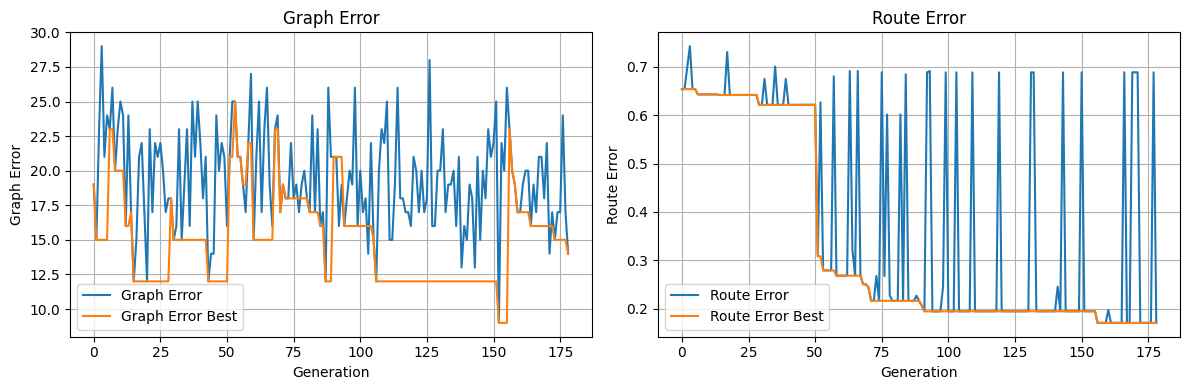

In [9]:
x = [gen_tuple[0] for gen_tuple in gen_log]
y_weighted_error = [gen_tuple[2] for gen_tuple in gen_log]
y_graph_error = [gen_tuple[3] for gen_tuple in gen_log]
y_route_error = [gen_tuple[4] for gen_tuple in gen_log]

y_weighted_error_best = [gen_tuple[2] for gen_tuple in best_log]
y_graph_error_best = [gen_tuple[3] for gen_tuple in best_log]
y_route_error_best = [gen_tuple[4] for gen_tuple in best_log]


fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Top subplot: Graph Error
axs[0].plot(x, y_graph_error, label='Graph Error')
axs[0].plot(x, y_graph_error_best, label='Graph Error Best')
axs[0].set_xlabel("Generation")
axs[0].set_ylabel("Graph Error")
axs[0].set_title("Graph Error")
axs[0].legend()
axs[0].grid(True)

# Bottom subplot: Route Error
axs[1].plot(x, y_route_error, label='Route Error')
axs[1].plot(x, y_route_error_best, label='Route Error Best')
axs[1].set_xlabel("Generation")
axs[1].set_ylabel("Route Error")
axs[1].set_title("Route Error")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

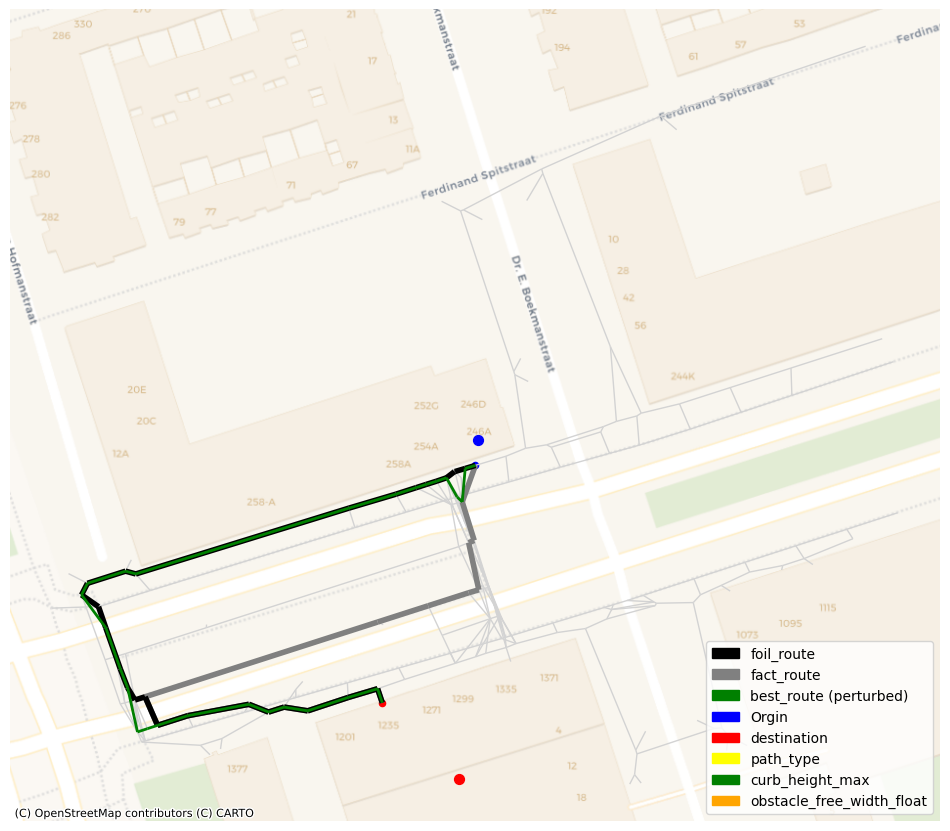

In [10]:
gdf_coords = ls.gdf_coords.copy()
origin_node_loc_length = ls.origin_node_loc
dest_node_loc_length = ls.dest_node_loc

# Subset network for plotting
my_rad = 70
gdf_coords['buffer'] = gdf_coords['geometry'].buffer(my_rad, cap_style=3)
plot_area = gpd.GeoDataFrame(geometry=[gdf_coords['buffer'][0].union(gdf_coords['buffer'][1])], crs=meta_map["CRS"])
df_sub = gpd.sjoin(ls.df, plot_area, how='inner').reset_index()


attrs_color = {"path_type": {"c":"yellow","ls": "-", "lw": 5}, 
               "curb_height_max": {"c":"green","ls": "-", "lw": 4}, 
               "obstacle_free_width_float": {"c":"orange","ls": "-", "lw": 3}}
fig, ax = plt.subplots(figsize=(12,12))

# Network
df_sub.plot(ax=ax, color='lightgrey', linewidth=1)

ls.df_path_fact.plot(ax=ax, color='grey', linewidth=4)
ls.df_path_foil.plot(ax=ax, color='black', linewidth=4)
best_route[0].plot(ax=ax, color='green', linewidth=2)

# not_common_edges_df.plot(ax=ax, color='yellow', linewidth=2)
# Origin and destination location
gdf_coords.head(1).plot(ax=ax, color='blue', markersize=50)
gdf_coords.tail(1).plot(ax=ax, color='red', markersize=50)

# Origin and destination nodes
gpd.GeoSeries([origin_node_loc_length], crs=meta_map["CRS"]).plot(ax=ax, color='blue', markersize=20)
gpd.GeoSeries([dest_node_loc_length], crs=meta_map["CRS"]).plot(ax=ax, color='red', markersize=20)

# Background
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Voyager, crs=meta_map["CRS"])

# Legend
route_acc = mpatches.Patch(color='black', label='foil_route')
route = mpatches.Patch(color='grey', label='fact_route')
route_best = mpatches.Patch(color='green', label='best_route (perturbed)')
origin = mpatches.Patch(color='blue', label= 'Orgin')
dest = mpatches.Patch(color='red', label= 'destination')
legend_handles = [route_acc,route,route_best,origin,dest]
for attr, color in attrs_color.items():
    legend_handles.append(mpatches.Patch(color=color["c"], label=attr))


plt.legend(handles=legend_handles,loc="lower right")

plt.axis('off')

plt.show()

# Store results

In [18]:
from utils.dataparser import store_op_list, load_op_list
from utils.graph_op import pertub_with_op_list
from utils.dataparser import convert
from shapely import to_wkt

v_op_list = get_virtual_op_list(ls.df, best_df[0], args["attrs_variable_names"])
available_op = [(op[0], (convert(op[1][0]), to_wkt(op[1][1], rounding_precision=-1, trim=False)), convert(op[2]), op[3]) for op in v_op_list if op[3] == "success"]
#test store and load op list
store_path = "./examples/demo_walk/outputs/"
store_op_path = f'{store_path}op_list_{route_name}_{route_id}.json'
with open(store_op_path, 'w') as f:
    json.dump(available_op, f)

best_route[0].to_file(f'{store_path}p_route_{route_name}_{route_id}', driver='GPKG')
best_df[0].to_file(f'{store_path}p_network_{route_name}_{route_id}', driver='GPKG')
